#📌 Extraction

In [2]:
# Librarys used here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tabulate as tabulate
import folium
from pandas import json_normalize
from folium.plugins import HeatMap
import warnings
import dfply as dp

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import json

#### Diccionario de datos

- `customerID`: número de identificación único de cada cliente
- `Churn`: si el cliente dejó o no la empresa
- `gender`: género (masculino y femenino)
- `SeniorCitizen`: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- `Partner`: si el cliente tiene o no una pareja
- `Dependents`: si el cliente tiene o no dependientes
- `tenure`: meses de contrato del cliente
- `PhoneService`: suscripción al servicio telefónico
- `MultipleLines`: suscripción a más de una línea telefónica
- `InternetService`: suscripción a un proveedor de internet
- `OnlineSecurity`: suscripción adicional de seguridad en línea
- `OnlineBackup`: suscripción adicional de respaldo en línea
- `DeviceProtection`: suscripción adicional de protección del dispositivo
- `TechSupport`: suscripción adicional de soporte técnico, menor tiempo de espera
- `StreamingTV`: suscripción de televisión por cable
- `StreamingMovies`: suscripción de streaming de películas
- `Contract`: tipo de contrato
- `PaperlessBilling`: si el cliente prefiere recibir la factura en línea
- `PaymentMethod`: forma de pago
- `Charges.Monthly`: total de todos los servicios del cliente por mes
- `Charges.Total`: total gastado por el cliente

In [3]:
with open("TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df1= json_normalize(data) 
df1= pd.DataFrame(df1)
df1.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [4]:
# create a summary DataFrame with the required statistics
# including the number of nulls, unique values, max, min, mean, and standard
df1.replace(["" , " "], np.nan, inplace=True)

summary = pd.DataFrame({
    'Columna': df1.columns,
    'Tipo de Dato': df1.dtypes.values,
    'Nulos': df1.isnull().sum().values,
    'Únicos': df1.nunique().values
})


summary = summary.sort_values(by='Nulos', ascending=False).reset_index(drop=True)


print(summary.to_markdown(index=False))

| Columna                   | Tipo de Dato   |   Nulos |   Únicos |
|:--------------------------|:---------------|--------:|---------:|
| Churn                     | object         |     224 |        2 |
| account.Charges.Total     | object         |      11 |     6530 |
| customerID                | object         |       0 |     7267 |
| customer.SeniorCitizen    | int64          |       0 |        2 |
| customer.gender           | object         |       0 |        2 |
| customer.Partner          | object         |       0 |        2 |
| customer.Dependents       | object         |       0 |        2 |
| phone.PhoneService        | object         |       0 |        2 |
| customer.tenure           | int64          |       0 |       73 |
| internet.InternetService  | object         |       0 |        3 |
| internet.OnlineSecurity   | object         |       0 |        3 |
| internet.OnlineBackup     | object         |       0 |        3 |
| phone.MultipleLines       | object         |  

Antes de iniciar el análisis de evasión de clientes, es fundamental aplicar una serie de transformaciones al dataset para garantizar su calidad. Primero, es necesario aplanar la estructura anidada del JSON utilizando `pd.json_normalize()`, lo que facilita el acceso a las variables. Luego, se deben reemplazar cadenas vacías `""` por valores nulos (`NaN`) para su correcta identificación y manejo. Es crucial convertir columnas numéricas que vienen como texto, como `account.Charges.Total`, a tipo `float`, y transformar columnas categóricas (`gender`, `Partner`, etc.) al tipo `category`, optimizando así el uso de memoria. También se recomienda unificar formatos y corregir inconsistencias como valores mal escritos o no estándar. La variable objetivo `Churn` debe convertirse a binaria (`Yes` = 1, `No` = 0) para facilitar su análisis. Se deben revisar y tratar los valores nulos, ya sea imputándolos o eliminándolos según el caso. Además, es importante eliminar duplicados y verificar la consistencia lógica entre variables relacionadas (por ejemplo, si `PhoneService` es "No", entonces `MultipleLines` no debe estar activo). Estas transformaciones aseguran un dataset limpio, estructurado y listo para generar insights confiables.


#🔧 Transformations

In [5]:

# trasform the DataFrame to have a more readable format

cat_cols = [ 'customer.gender','internet.InternetService','account.Contract','account.PaymentMethod',
            'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']
for col in cat_cols:
    df1[col] = df1[col].astype('category')


# convert the 'customer.SeniorCitizen' column to boolean

cat_cols = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
    'account.PaperlessBilling', 'Churn','customer.SeniorCitizen']

# remplace Yes/No with 1/0

df1 = df1.replace({'Yes': 1, 'No': 0})

for col in cat_cols:
    df1[col] = df1[col].astype('bool')
    

# convert the 'account.Charges.Total' column to float
df1['account.Charges.Total'] = df1['account.Charges.Total'].astype(float)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7267 non-null   object  
 1   Churn                      7267 non-null   bool    
 2   customer.gender            7267 non-null   category
 3   customer.SeniorCitizen     7267 non-null   bool    
 4   customer.Partner           7267 non-null   bool    
 5   customer.Dependents        7267 non-null   bool    
 6   customer.tenure            7267 non-null   int64   
 7   phone.PhoneService         7267 non-null   bool    
 8   phone.MultipleLines        7267 non-null   bool    
 9   internet.InternetService   7267 non-null   category
 10  internet.OnlineSecurity    7267 non-null   category
 11  internet.OnlineBackup      7267 non-null   category
 12  internet.DeviceProtection  7267 non-null   category
 13  internet.TechSupport       7267 n

#📊 Load and Analysis

In [11]:
# load data base in .CSV format
df1.to_csv("TelecomX_Data_Cleaned.csv", index=False)


In [8]:
df1.describe(include='all')

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
count,7267,7267,7267,7267,7267,7267,7267.000000,7267,7267,7267,...,7267.0,7267.0,7267.0,7267.0,7267.0,7267,7267,7267,7267.000000,7256.000000
unique,7267,2,2,2,2,2,NaN,2,2,3,...,3.0,3.0,3.0,3.0,3.0,3,2,4,NaN,NaN
top,9995-HOTOH,False,Male,False,False,False,NaN,True,True,Fiber optic,...,0.0,0.0,0.0,0.0,0.0,Month-to-month,True,Electronic check,NaN,NaN
freq,1,5174,3675,6085,3749,5086,NaN,6560,3772,3198,...,3182.0,3195.0,3582.0,2896.0,2870.0,4005,4311,2445,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,32.346498,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.720098,2280.634213
std,NaN,NaN,NaN,NaN,NaN,NaN,24.571773,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.129572,2268.632997
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.425000,400.225000
50%,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.300000,1391.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.875000,3785.300000


# columns that are strcategorical 

In [13]:
cat_cols = df1.select_dtypes(include='object').columns

top_cat_summary = []

for col in cat_cols:
    top_values = d1[col].value_counts(dropna=False).head(3)
    for value, count in top_values.items():
        top_cat_summary.append({
            'Columna': col,
            'Categoría': str(value),
            'Frecuencia': count
        })

top_cat_df = pd.DataFrame(top_cat_summary)



# sort the DataFrame by 'Columna' and 'Frecuencia'
print(top_cat_df.to_markdown(index=False))

NameError: name 'd1' is not defined

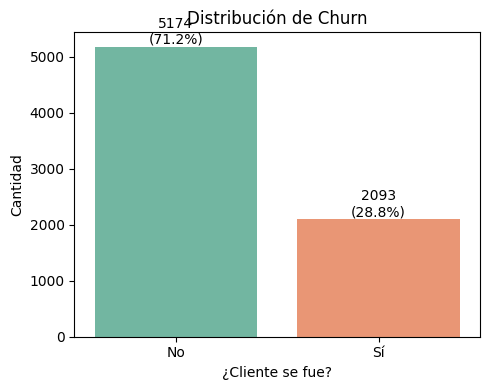

In [ ]:
# 1. Distribución de Churn con Porcentajes
plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Churn', data=df1, palette='Set2')
plt.title("Distribution of Churn")
plt.xlabel("Churn of customers")
plt.ylabel("Count")
plt.xticks([0, 1], ['No', 'Yes'])

# Calcular proporciones
total = len(df1)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count}\n({percent:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

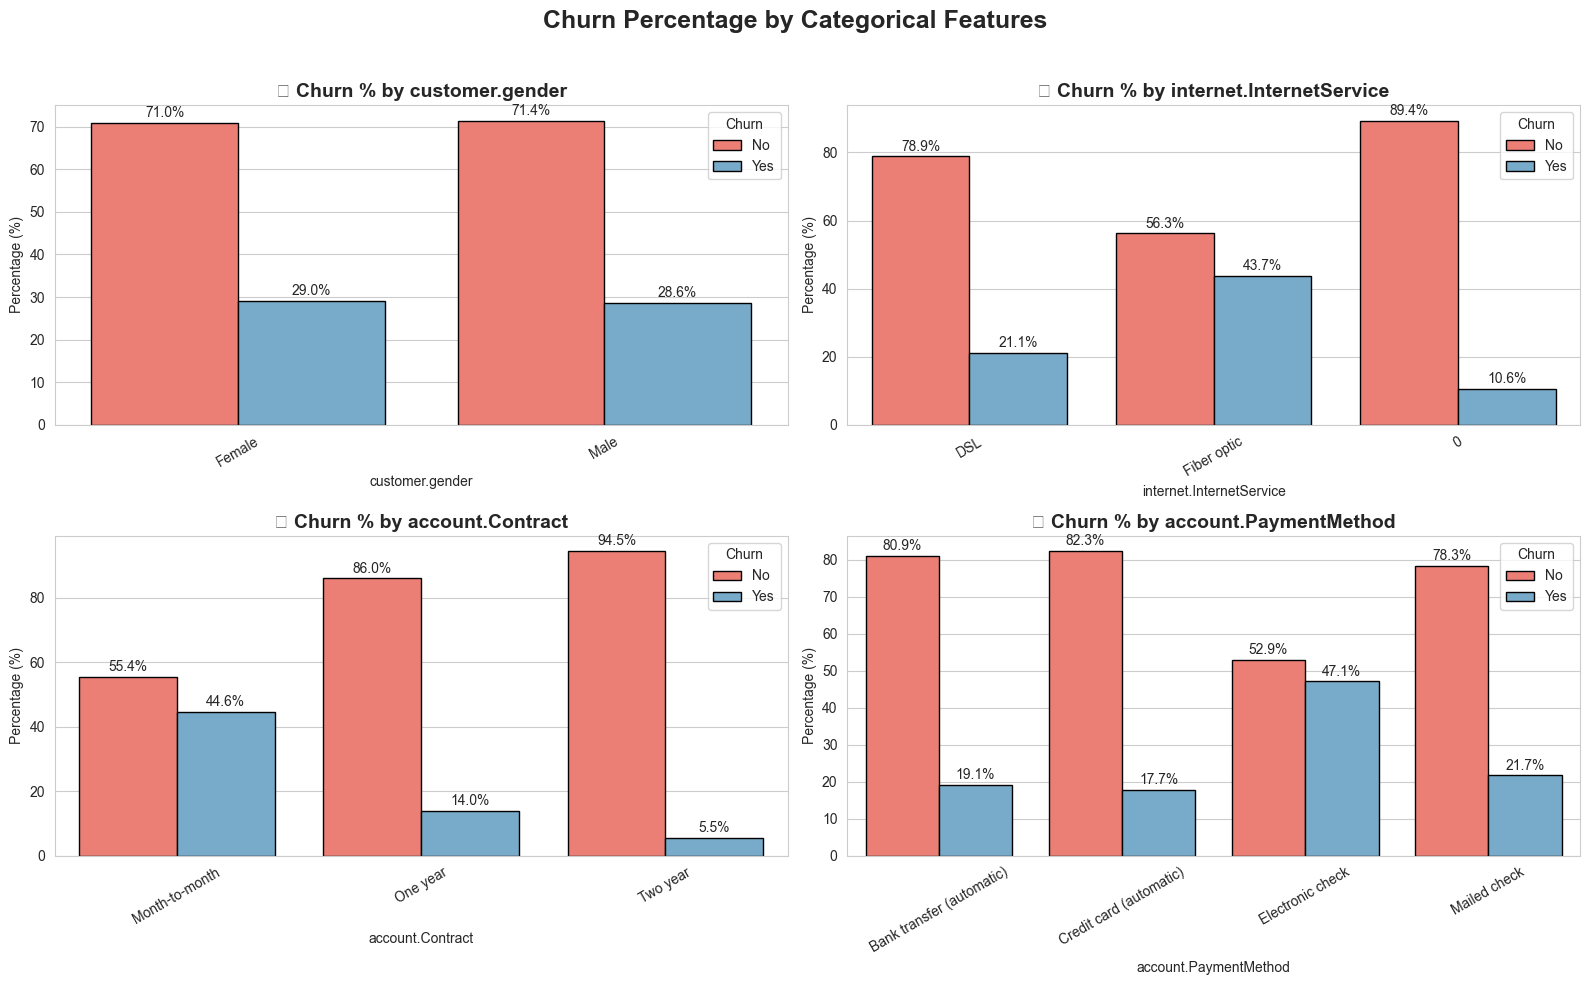

In [ ]:
sns.set_style("whitegrid")
custom_palette = ['#FF6F61', '#6BAED6']  # Churn = Yes, No

cat_features = [
    'customer.gender',
    'internet.InternetService',
    'account.Contract',
    'account.PaymentMethod'
]

n = len(cat_features)
rows = (n + 1) // 2

fig, axes = plt.subplots(rows, 2, figsize=(16, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    temp_df = df1.copy()
    temp_df['Churn'] = temp_df['Churn'].map({True: 'Yes', False: 'No'})
    
    grouped = temp_df.groupby([feature, 'Churn']).size().reset_index(name='count')
    grouped['total'] = grouped.groupby(feature)['count'].transform('sum')
    grouped['Percentage'] = 100 * grouped['count'] / grouped['total']
    
    sns.barplot(
        data=grouped,
        x=feature,
        y='Percentage',
        hue='Churn',
        palette=custom_palette,
        ax=axes[i],
        edgecolor='black'
    )
    
    axes[i].set_title(f'📊 Churn % by {feature}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(feature)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].legend(title='Churn', loc='upper right')
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', padding=2, fontsize=10)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Churn Percentage by Categorical Features', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


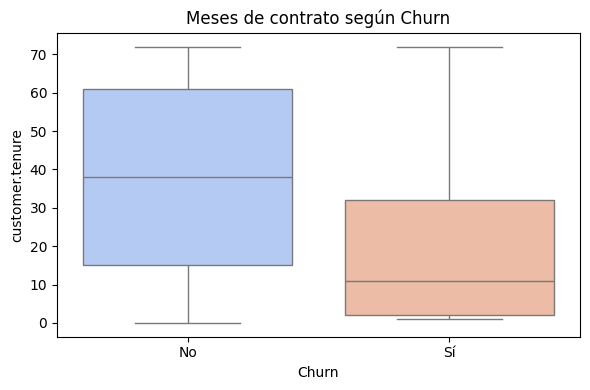

In [ ]:
# 2. Tenure promedio según churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='customer.tenure', data=df1, palette='coolwarm')
plt.title("Meses de contrato según Churn")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

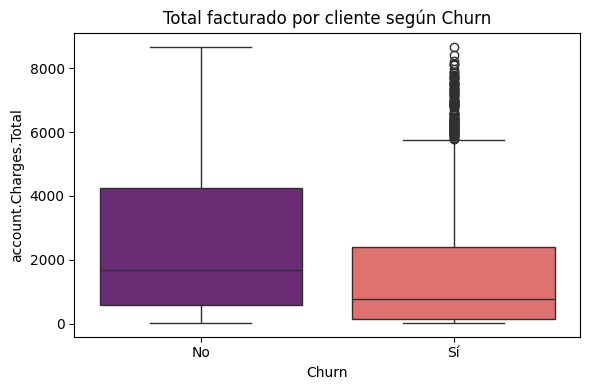

In [ ]:
# 4. Total acumulado vs churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df1, palette='magma')
plt.title("Total facturado por cliente según Churn")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

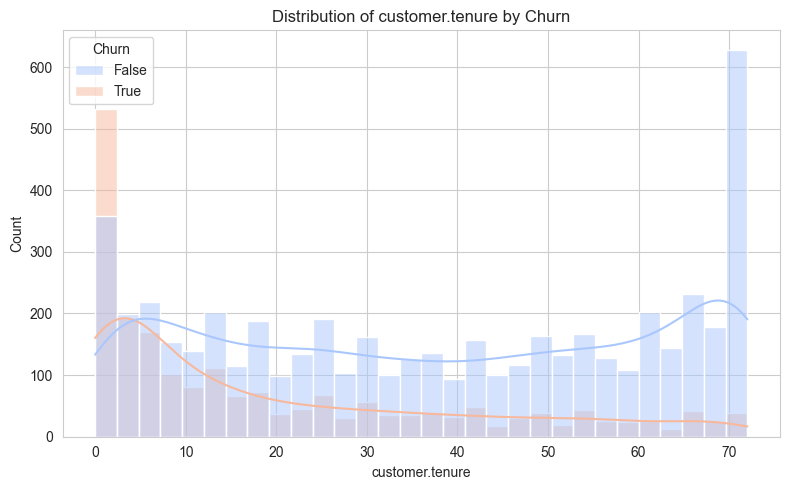

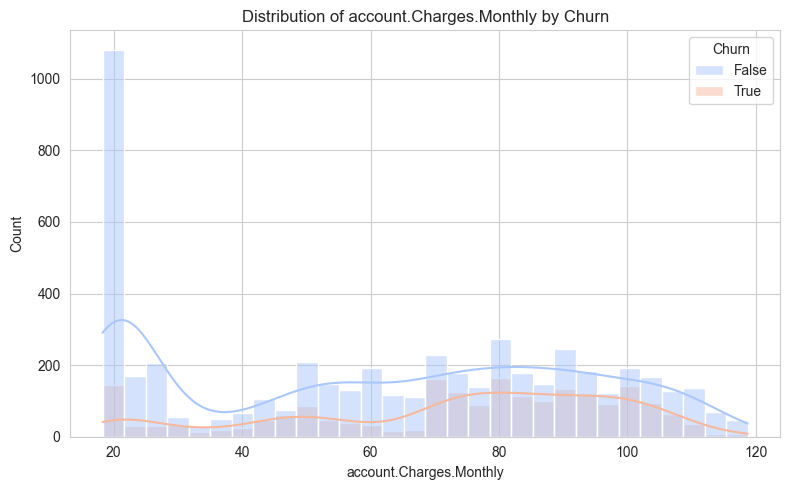

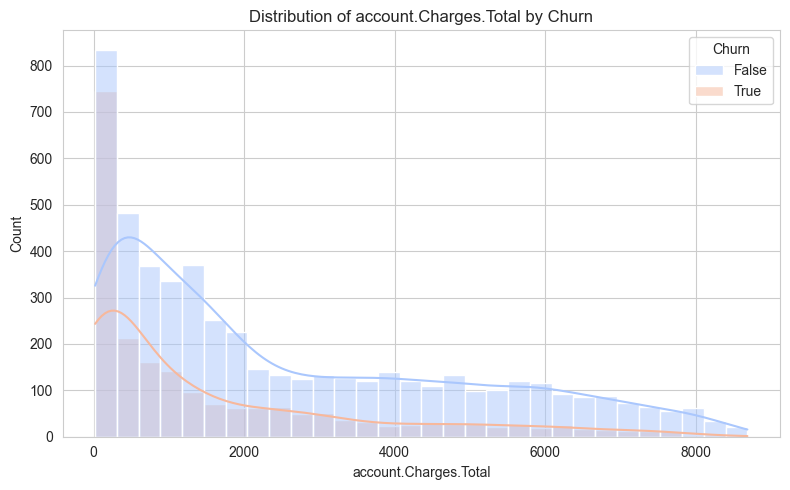

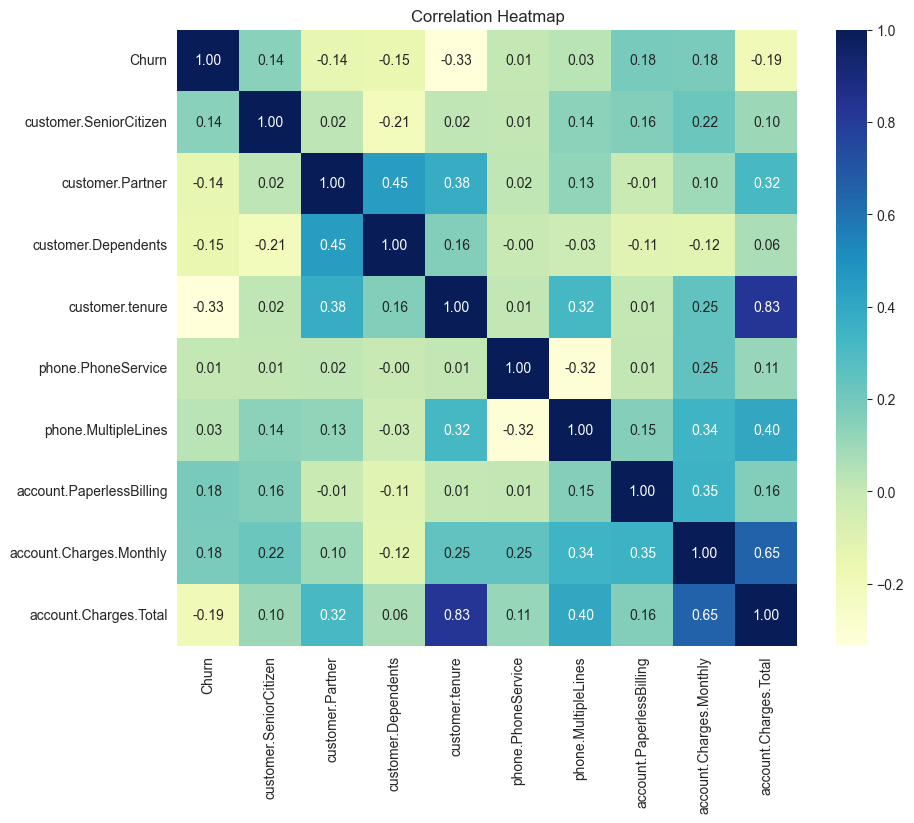

In [ ]:
# --- 5. Churn by Numerical Features ---
numeric_features = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

for feature in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df1, x=feature, hue='Churn', kde=True, palette='coolwarm', bins=30)
    plt.title(f"Distribution of {feature} by Churn")
    plt.tight_layout()
    plt.show()

# --- 6. Correlation Analysis ---
plt.figure(figsize=(10, 8))
corr = df1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

#📄Informe final

## 📘 Informe Final — Análisis Exploratorio sobre La Evasión de Clientes en TelecomX LATAM

---

### 🔹 Introducción

La evasión de clientes, conocida como *churn*, representa una de las amenazas más significativas para las empresas de servicios, especialmente en el sector de las telecomunicaciones. Retener un cliente existente suele ser más rentable que adquirir uno nuevo, lo que hace del análisis de churn una prioridad para ganacias y vitalidad de los negocios.  

En este proyecto, se llevó a cabo un análisis de datos de clientes de **TelecomX LATAM** con el objetivo de identificar patrones, comportamientos y características asociadas al abandono del servicio.

---

### 🔹 Limpieza y Tratamiento de Datos

Primeramente se realiza la limpieza de datos tiendolo como un preprocesamiento de los datos:

- **Importación del dataset:** Se cargó el archivo con la información de clientes, servicios contratados y estado de churn.
- **Exploración inicial:** Se revisó la estructura del DataFrame, nombres de columnas, tipos de variables y resumen estadístico general.
- **Tratamiento de valores faltantes y anómalos:**  
  - Se imputaron o eliminaron registros con valores nulos según la criticidad de cada variable.
  - Se revisaron registros con valores inconsistentes (por ejemplo, duración igual a 0 con servicios contratados).
- **Conversión de tipos:** Se aseguraron los formatos adecuados (fechas, enteros, booleanos, strings).
- **Transformación de variables categóricas:** Se aplicó codificación si fue necesario para etapas posteriores de modelado (label encoding u one-hot encoding).


---

### 🔹 Análisis Exploratorio de Datos (EDA)

El análisis exploratorio se enfocó en entender cómo distintas variables influencian la probabilidad de churn y otro comportamiento de la empresa TelecomX.

### ✅ Principales hallazgos:

#### 1. **Distribución del churn**

- Alrededor del **28%** de los clientes ha abandonado el servicio.
- Esto refleja un **problema relevante de retención** mas aun no es tan alto el problema.

#### 2. **Tipo de contrato**

- Los clientes con **contratos mensuales** presentan tasas de churn significativamente más altas que aquellos con contratos anuales o bianuales.
- La flexibilidad del contrato mensual parece traducirse en una menor fidelidad.

#### 3. **Método de pago**

- El método de **pago electrónico automático** mostró una tasa de churn mayor en comparación con otros métodos.
- Esto podría estar vinculado a la experiencia de pago o a la percepción de control del cliente.

#### 4. **Servicios contratados**

- Los clientes que **no cuentan con servicios de Internet** o **TV** son más propensos a abandonar.
- A mayor número de servicios contratados, menor es la probabilidad de churn.

#### 5. **Duración como cliente**

- Clientes con **menos de 6 meses** en la compañía presentan una mayor tasa de churn.
- Indica una posible **falla en el proceso de onboarding o fidelización inicial**.

#### 6. **Segmentación por género, tipo de servicio y características técnicas**

- Variables como el tipo de servicio (fibra óptica vs DSL) también mostraron relación con el churn.
- No se encontró una diferencia significativa por género.



---

### 🔹 Conclusiones e Insights

A partir del análisis realizado, se destacan los siguientes puntos críticos:

1. **Contratos cortos y flexibles** → alta vulnerabilidad al churn.
2. **Clientes nuevos** → más propensos a abandonar si no se les brinda una experiencia de valor desde el inicio.
3. **Servicios básicos sin complementariedad** → menos fidelización.
4. **Pagos electrónicos sin intervención** → requieren revisión del proceso de experiencia de usuario.
5. **Valor mensual alto sin justificación clara de servicio** → se asocia con fuga de clientes.

- Sobre la matriz de correlación se obtuvieron los siguientes hallazgos:

- **`tenure` y `TotalCharges`** tienen una **alta correlación positiva**, lo cual es esperable, ya que a mayor tiempo con la compañía, mayor acumulación de cargos totales.
- **`MonthlyCharges`** tiene una **correlación moderada** con `TotalCharges`, pero no con `tenure`, lo que sugiere que los cargos mensuales varían ampliamente entre clientes, sin importar su antigüedad.
- La variable **`Churn`** muestra **correlaciones negativas** con `tenure` y `TotalCharges`, indicando que:
  - Los clientes con **menos tiempo (tenure bajo)** tienden más al churn.
  - Aquellos que **han pagado más a lo largo del tiempo (TotalCharges alto)** son más propensos a permanecer.
- `MonthlyCharges` tiene una **correlación ligeramente positiva con churn**, sugiriendo que **clientes con cargos mensuales más altos** podrían estar más insatisfechos o propensos a irse.


---

### 🔹 Recomendaciones Estratégicas

Basado en los hallazgos, se proponen las siguientes acciones:

#### 1. **Rediseñar los contratos de corto plazo**

- Incentivar la migración a contratos anuales mediante descuentos, bonos o servicios gratuitos.

#### 2. **Refuerzo del onboarding**

- Implementar campañas de bienvenida y seguimiento personalizado durante los primeros 60 días.

#### 3. **Bundles y ofertas integradas**

- Promover servicios combinados (Internet + TV + Telefonía) con beneficios adicionales.

#### 4. **Optimización de experiencia de pago**

- Mejorar la interfaz y claridad del sistema de pagos electrónicos.
- Incluir notificaciones, comprobantes detallados y opciones más claras.



---